In [1]:
# Libraries import 
import tensorflow as tf
#from tensorflow_federated import python as tff
import os
import numpy as np
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist,cifar10
from keras.optimizers import Adam
from keras import initializers
from tqdm import tqdm

Using TensorFlow backend.


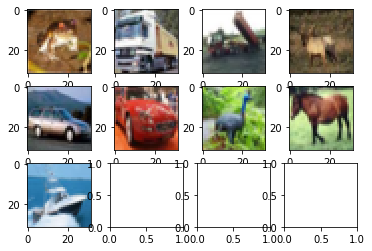

In [4]:
# Load and Normalize Data 
# 1. MNIST/EMNIST Data - handwritten things 
from emnist import extract_training_samples
def normalize(data, factor): 
    return ((data-factor)/factor)
def load_handwritten_data(digits_only=True):
    # load data
    if(digits_only): 
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else: 
        x_, y_ = extract_training_samples('letters')
        test_ind = np.random.randint(0, x_.shape[0], int(1/7*x_.shape[0]))
        x_test, y_test = x_[test_ind,...], y_[test_ind,...]
        x_train, y_train = np.delete(x_, test_ind, axis=0), np.delete(y_, test_ind,axis=0)
    
    # normalize data 
    normal_train_factor, normal_test_factor = np.max(x_train.flatten())/2, np.max(x_test.flatten())/2
    x_train, x_test = normalize(x_train, normal_train_factor), normalize(x_test, normal_test_factor)
    return(x_train, y_train, x_test, y_test)

# 2. CIFAR10 Dataset - 
def load_CIFAR_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    return(x_train, y_train, x_test, y_test)


# Visualizing the images 
import matplotlib.pyplot as plt
import math as m
def plot_imgs(imgs, plt_per_lines=4): 
    %matplotlib inline
    if(type(imgs) != list): 
        print("Please pass list of images")
        return
    n = len(imgs)
    fig, axs = plt.subplots(m.ceil(n/plt_per_lines),plt_per_lines)
    for i,ax in enumerate(axs.flat):
        if( i >= n): return
        ax.imshow(imgs[i], cmap="gray")
    plt.show()

# train, y_train, test, y_test  = load_handwritten_data()
train, y_train, test, y_test  = load_CIFAR_data()
#use LUMA coding to turn to grayscale 

plot_imgs([i for i in train[0:9, ...]])

In [7]:
# Basic descriminator 
def discriminator(n_classes, image_shape): 
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    
    #print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
    #with mirrored_strategy.scope():
    dmod = Sequential()
    print("dense")
    dmod.add(Dense(512, activation ='sigmoid', input_shape=(784,)))
    dmod.add(LeakyReLU(0.2))
    #dmod.add(Dropout(1-0.3)) #reduces overfitting 
    print("softmax")
    dmod.add(Dense(n_classes, activation='softmax'))
    print("compile")
    dmod.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.categorical_accuracy, 'accuracy'])
    print("done")
                  #,distribute=mirrored_strategy)
    return dmod

In [ ]:
# Example descriminator - implemented here https://www.datacamp.com/community/tutorials/generative-adversarial-networks
# discriminator = Sequential()
# discriminator.add(Dense(1072, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(1-0.3))

# discriminator.add(Dense(512))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(1-0.3))

# discriminator.add(Dense(256))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(1-0.3))

# discriminator.add(Dense(1, activation='sigmoid'))
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),  metrics=[tf.keras.metrics.categorical_accuracy, 'accuracy'])
# discriminator.evaluate(test.reshape(test.shape[0], test.shape[1]*test.shape[2]), y_test, batch_size=32)

In [8]:
# Train on MNIST
train, y_train, test, y_test  = load_handwritten_data()
y_ = np.eye(np.max(y_train)+1)[y_train.reshape(-1)]
image_shape = np.prod(train.shape[1:])
dmod = discriminator(np.max(y_train)+1, image_shape)
print("loaded_discriminator")
print("start testing")
dmod.fit(train.reshape(train.shape[0], -1), y_, epochs=10, batch_size=32 )

# Test on MNIST
y_t = np.eye(np.max(y_test)+1)[y_test.reshape(-1)]
dmod.evaluate(test.reshape(test.shape[0], -1), y_t, batch_size=32)

dense
softmax
compile
done
loaded_discriminator
start testing
Epoch 1/10
41408/60000 [===================>..........] - ETA: 2s - loss: 0.0609 - categorical_accuracy: 0.8894 - acc: 0.9792

KeyboardInterrupt: 

In [ ]:
# Train on EMNIST
etrain, eytrain, etest, eytest  = load_handwritten_data(False)
ey_  = np.eye(np.max(eytrain)+1)[eytrain.reshape(-1)]
image_shape = np.prod(etrain.shape[1:])
dmod = discriminator(np.max(eytrain)+1, image_shape)
dmod.fit(etrain.reshape(etrain.shape[0],-1), ey_, batch_size=32, epochs=10)

# Test on EMNIST
ey_t = np.eye(np.max(eytest)+1)[eytest.reshape(-1)]
dmod.evaluate(etest.reshape(etest.shape[0], -1), ey_t, batch_size=32)

In [ ]:
# Train on CIFAR
train, y_train, test, y_test  = load_CIFAR_data()
y_ = np.eye(np.max(y_train)+1)[y_train.reshape(-1)]
image_shape = np.prod(train.shape[1:])
dmod = discriminator(np.max(y_train)+1, image_shape)
print("loaded_discriminator")
print("start testing")
dmod.fit(train.reshape(train.shape[0], -1), y_, epochs=10, batch_size=32 )

# Test on CIFAR
y_t = np.eye(np.max(y_test)+1)[y_test.reshape(-1)]
dmod.evaluate(test.reshape(test.shape[0], -1), y_t, batch_size=32)

In [2]:
# Testing a generator 


Number of devices: 1
